In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm as LogNorm
from matplotlib import cm
import numpy as np
from tabulate import tabulate
from scipy import stats, special, signal
import h5py
from skimage.filters import try_all_threshold, threshold_minimum

# Features of Big(ish) Data

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
list(hf.keys())

['data']

In [3]:
data = np.array(hf.get('data'))
hf.close()

In [4]:
def plotpts(x,y,start,pts,step):
    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(22,8) 
    
    end = pts*step + start
    if end > len(x[0]):
        print("\nEndpoint exceeds array limit!\n")
    
    h1 = ax[0,0].hist2d(x[1][start:end:step],y[start:end:step],bins=70,density=True)
    ax[0,0].set_title('Solar Phase vs Counts',fontsize=14)
    #plt.colorbar(h1[3],ax=ax[0,0])
    
    ax[0,1].hist2d(x[2][start:end:step],y[start:end:step],bins=70,density=True)
    ax[0,1].set_title('Earth Longitude vs Counts',fontsize=14)
    
    ax[1,0].hist2d(x[0][start:end:step],y[start:end:step],bins=70,density=True)
    ax[1,0].set_title('Time vs Counts',fontsize=14)
    
    new = x[0]%5400
    ax[1,1].hist2d(new[start:end:step],y[start:end:step],bins=70,density=True)
    ax[1,1].set_title('Time vs Counts, Folded at 5,400 GPS seconds',fontsize=14)

In [5]:
def plotslice(x,y,start,end,step):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(14,6) 
    
    pts = (end-start)/step
    
    ax.scatter(x[start:end:step],y[start:end:step])    
    ax.set_title('{0:g} points -- starting at index {1:g} and ending at index {2:g} -- with step {3:g}'.format(pts,start,end,step),fontsize=14)

## Problem 1 - Gamma Ray Data Feature Characterizations

In this problem, we have more than 25 million data points from a gamma ray satellite orbiting in a low Earth orbit, passing us by every 90 min. It measures the number of particles, either gamma rays or cosmic rays, and logs a reading every 100 milliseconds (or 0.1 GPS seconds). The data also includes solar phase in degrees (position of the sun relative to the satellite's orbit around Earth), and Earth longitude in degrees (position of the satellite relative to ground).

In [6]:
#time in GPS seconds, Solar phase in degrees relative to Earth, Earth longitude in degrees of spacecraft position relative to ground, and particle counts
t,sol,lon,counts = data[0],data[1],data[2],data[3]
print("\nFor each column, we have {0:g} rows, and our time starts at {1:.1f} GPS seconds.\n".format(len(t),t[0]))


For each column, we have 2.592e+07 rows, and our time starts at 940680016.0 GPS seconds.



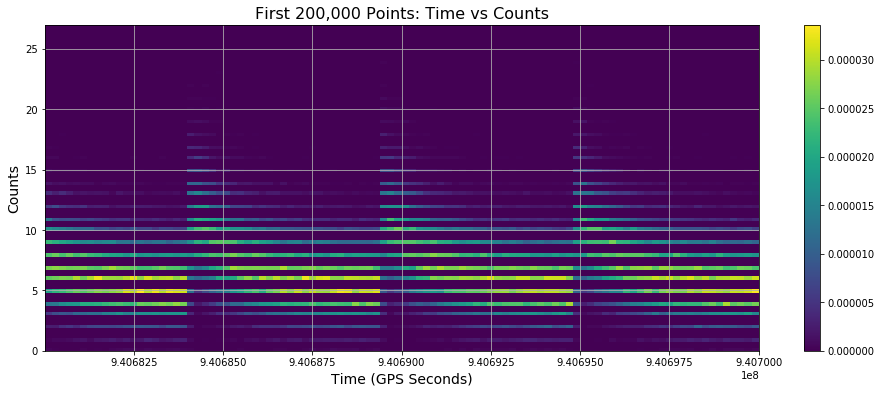

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

h = ax.hist2d(t[0:200000:1],counts[0:200000:1],bins=100, density=True);
ax.set_title('First 200,000 Points: Time vs Counts',fontsize=16)
ax.set_xlabel('Time (GPS Seconds)',fontsize=14)
ax.set_ylabel('Counts',fontsize=14)

plt.grid()
plt.colorbar(h[3], ax=ax);

This plot shows an interesting relationship with time and counts. It seems to reset after a predictable amount of time. My immediate guess is that as the spacecraft orbits the earth, it cycles in and out of being in direct contact with the sun. I am confused, however, by the sudden jump from min to max. I would have expected more of a sin curve. 

I beat my head against the wall trying to determine the exact orbital period without noticing it was given to us in the very beginning of the lab, so that was cool. 90min orbit = 5,400 seconds. A day is 86,400 seconds - so this is quite fast. In order to test my hypothesis about the sun being a source, I'll plot time vs solar phase. This time, I can fold the time axis, effectively making it so that all data falls within some portion of one orbital cycle.

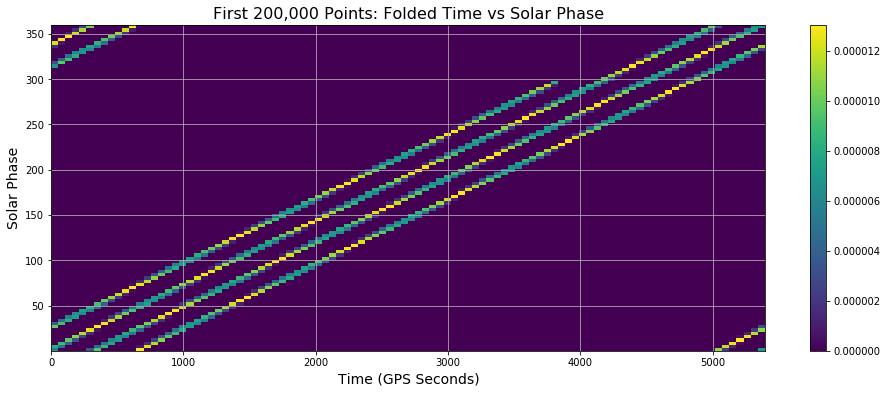

In [8]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

h1 = ax.hist2d(t[0:200000:1]%5400,sol[0:200000:1],bins=100, density=True);
ax.set_title('First 200,000 Points: Folded Time vs Solar Phase',fontsize=16)
ax.set_xlabel('Time (GPS Seconds)',fontsize=14)
ax.set_ylabel('Solar Phase',fontsize=14)

plt.grid()
plt.colorbar(h1[3], ax=ax);

Interesting! It appears that the solar phase changes with time at a different period as counts vs time. The four bands correspond to the four orbital cycles completed by the satellite. At each run, the solar phase is slightly off, and shifts. It seems to be uncorrelated with counts. Let's look at earth longitude.

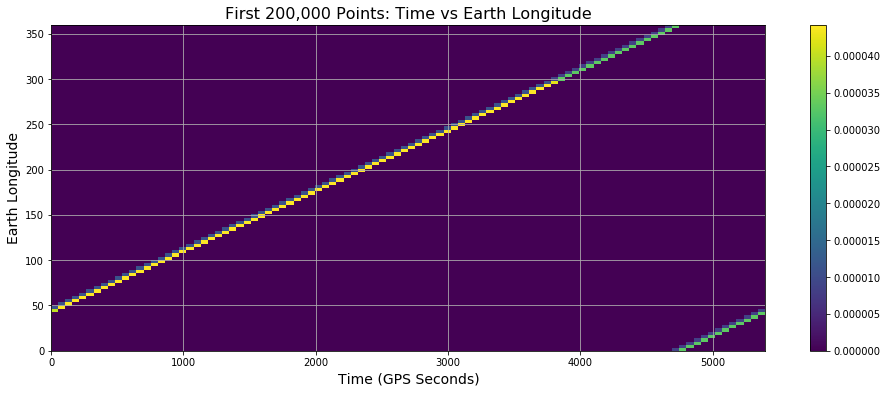

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16,6) 

h = ax.hist2d(t[0:200000:1]%5400,lon[0:200000:1],bins=100, density=True);
ax.set_title('First 200,000 Points: Time vs Earth Longitude',fontsize=16)
ax.set_xlabel('Time (GPS Seconds)',fontsize=14)
ax.set_ylabel('Earth Longitude',fontsize=14)

plt.grid()
plt.colorbar(h[3], ax=ax);

Ooo. The rate at which the satellite orbits is directly correlated to its change in longitude. I was excited at first, because if it were latitude, we could be talking about redirection of cosmic rays via the magnetic field up to the north pole, but nope, I mixed up longitude and latitude. Anyways. It appears as if 4,000 seconds into its orbit is where we suddenly have less data. This was fascinating - at this longitude, is it harder to take data?

There could be tons of factors at play, so let's make a few more plots.

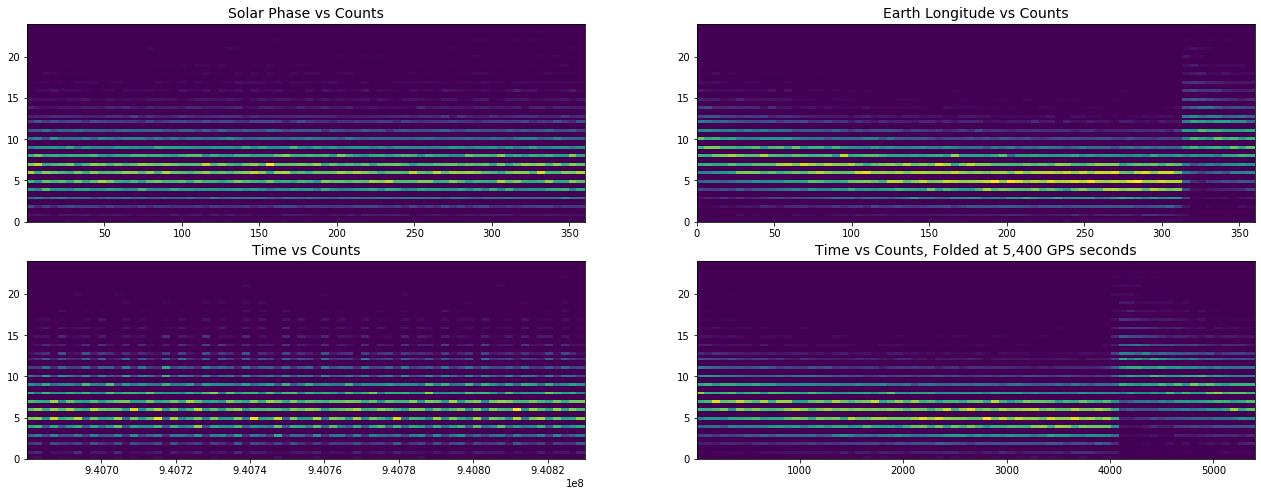

In [10]:
plotpts(data,counts,start=0,pts=50000,step=30)

From this, we can see that we were right about the lack of correlation between counts and solar phase, which rules out my hypothesis. Earth Longitude clearly has a distinct correlation with counts, where there is a sharp, distinct rise at an earth longitude of 315 degrees or so. Using the plot above, we can confirm that the satellite reaches 315 degrees around 4,100 seconds into its orbit. The histogram has assigned a greener color because the spread is larger, and more bins are being populated by the same number of points. The peak seems significant, but the variation needs to be addressed.

So, as far as characterizing each of these plots with a distribution in which they pull x number of counts - I plan on assigning a poisson distribution to the solar phase, with mean 6. Earth Longitude is trickier - it is far more likely to pull a high count number when at a degree of 315 or so. Because of this, I would think that I would be looking at Rayleigh or related discrete distribution with an asymmetric tail, but since I cannot fathom of why a specific longitude would yield higher gamma-ray, I'm considering the possibility of signal contamination due to local interference. Depending on map, the satellite experiences interference above Brazil. Lol. Nothing comes to mind. Maybe there's a huge amount of material that is able to scatter cosmic rays back at the satellite. Or maybe the satellite heats up and detects more particles, leading to the sudden mean of 10 which steadily drops for 100 degrees - which I realize now spans the entire Atlantic Ocean. Weird.

Whatever the case may be, the background pdf of cosmic rays should be time dependent. To do this, we can combine two poisson distributions - one centered at 10 for t > 4000, and one centered at 6 for t < 4000.

In [11]:
#constructing a pdf

time = np.linspace(0,5399,5400)
pmf1 = []

for i in range(len(time)):
    if time[i] < 4000:
        reg = stats.poisson.rvs(6)
        pmf1.append(reg)
    if time[i] >= 4000:
        weird = stats.poisson.rvs(10)
        pmf1.append(weird)

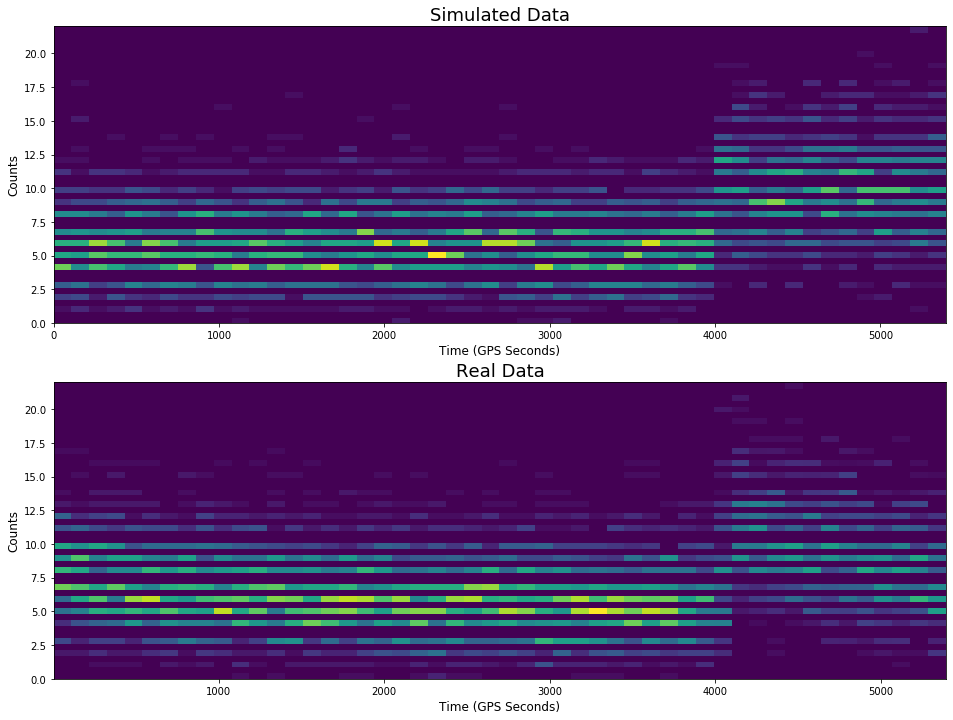

In [12]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(16,12) 

ax[0].hist2d(time,pmf1,bins=50,density=True)
ax[0].set_title('Simulated Data',fontsize=18);
ax[0].set_xlabel('Time (GPS Seconds)',fontsize=12)
ax[0].set_ylabel('Counts',fontsize=12)

newt = t%5400
ax[1].hist2d(newt[0:200000:30],counts[0:200000:30],bins=50,density=True);
ax[1].set_title('Real Data',fontsize=18)
ax[1].set_xlabel('Time (GPS Seconds)',fontsize=12)
ax[1].set_ylabel('Counts',fontsize=12);

My model is alright. I looks good side by side with the real data, but it doesn't capture the downward slant after 4,000 seconds.

In [13]:
prob6 = stats.poisson.cdf(22,mu=6)
sig6 = stats.norm.ppf(prob6)

prob10 = stats.poisson.cdf(29,mu=10)
sig10 = stats.norm.ppf(prob10)

print("\nThe count corresponding to a five sigma amount is 22 for the distribution before t=4000s, and 29 for after t=4000s.\n")


The count corresponding to a five sigma amount is 22 for the distribution before t=4000s, and 29 for after t=4000s.



# Problem 2 - Image Stack Features - Faintest Stars

In this problem, we are given a stack of 10 images, 200 by 200 pixels, taken of the sky in presumably the visual field. My chosen target is the search for the faintest stars in the images.

In [14]:
hfp = h5py.File('images.h5', 'r')
list(hfp.keys())

['image1', 'imagestack']

In [15]:
im1 = np.array(hfp.get('image1'))
ims = np.array(hfp.get('imagestack'))
hfp.close()

In [16]:
ims.shape[0]

200

In [17]:
print("\nFor our first image, the smallest pixel value is {0:.3f} and largest is {1:.3f}, with a mean of {2:.3f}. \n".format(
    ims[:,:,0].min(),ims[:,:,0].max(),ims[:,:,0].mean()))
print("For our last image, the smallest pixel value is {0:.3f} and largest is {1:.3f}, with a mean of {2:.3f}.\n".format(
    ims[:,:,9].min(),ims[:,:,9].max(),ims[:,:,9].mean()))


For our first image, the smallest pixel value is -2.284 and largest is 46.012, with a mean of 0.030. 

For our last image, the smallest pixel value is -2.444 and largest is 47.213, with a mean of 0.036.




Average value of the difference in images is -0.007.



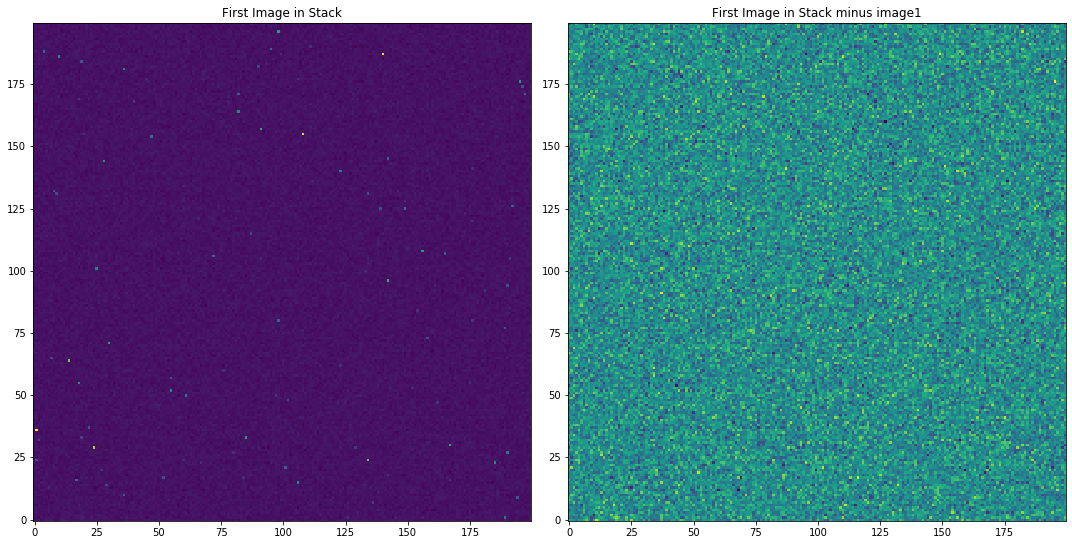

In [18]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,15)

ax[0].imshow(ims[:,:,0],origin='lower')
ax[0].set_title('First Image in Stack')

diff = ims[:,:,0]-im1
ax[1].imshow(diff,origin='lower')
ax[1].set_title('First Image in Stack minus image1')

fig.tight_layout()

print("\nAverage value of the difference in images is {0:.3f}.\n".format(diff.mean()))


Images have very similar background distribution, centered at 0, with no time dependency at this pixel level. Let's try fitting a Gaussian...



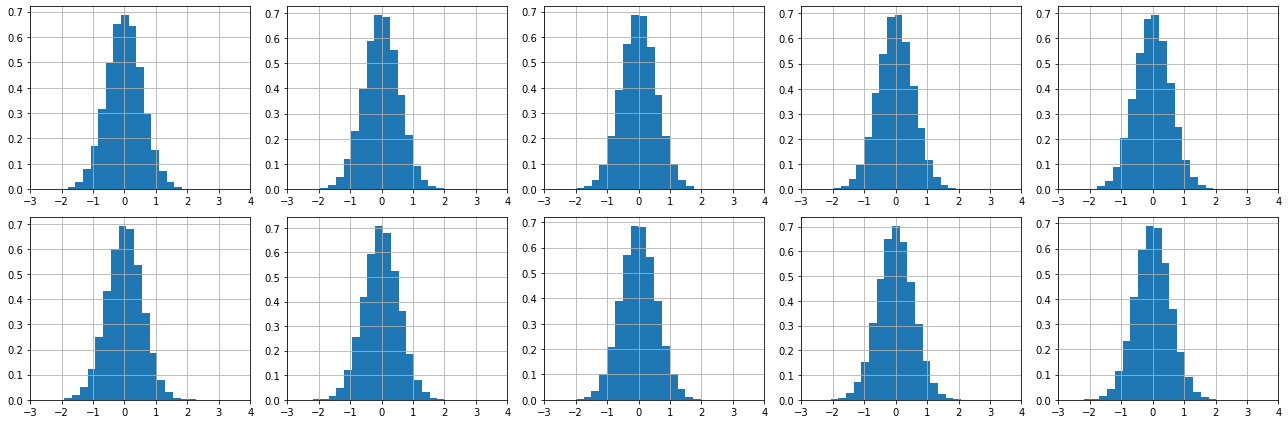

In [19]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(18,6)

for i in range(10):
    if i <= 4:
        ax[0,i].hist(ims[:,:,i].flatten(),bins=200,density=True);
        ax[0,i].set_xlim(-3,4)
        ax[0,i].grid()
    if i > 4:
        ax[1,i-5].hist(ims[:,:,i].flatten(),bins=200,density=True);
        ax[1,i-5].set_xlim(-3,4)
        ax[1,i-5].grid()

fig.tight_layout()

print("\nImages have very similar background distribution, centered at 0, with no time dependency at this pixel level. Let's try fitting a Gaussian...\n")


Yay, this looks good. Now that we have our background, we can safely threshold at a pixel value of 2 to find sources.



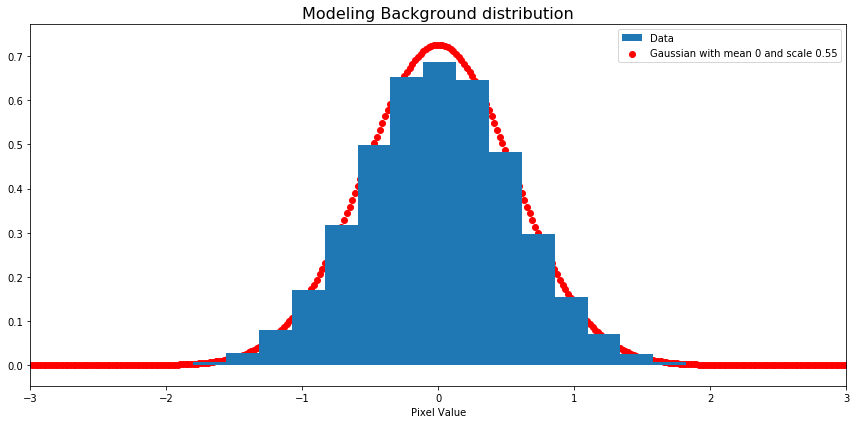

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)

s = np.linspace(-3,3,300)
sky = stats.norm.pdf(s,scale=0.55)
ax.scatter(s,sky,c='r',label='Gaussian with mean 0 and scale 0.55')
ax.hist(ims[:,:,0].flatten(),bins=200,density=True,label='Data');

ax.set_xlim(-3,3)
ax.set_xlabel('Pixel Value')
ax.set_title('Modeling Background distribution',fontsize=16)

plt.legend()
fig.tight_layout()

print('\nYay, this looks good. Now that we have our background, we can safely threshold at a pixel value of 2 to find sources.\n')

In [21]:
low_thresh = 2.
clean = np.empty((10,40000))

for i in range(10):
    clean[i] = ims[:,:,i].flatten()
    for j in range(200*200):
        if clean[i][j] < low_thresh:
            clean[i][j] = 0.

print("\nFrom printing a section of our new image arrays, we can see that we have effectively minimized the background, and are left with point sources.\n")
print(clean[0][200:400])


From printing a section of our new image arrays, we can see that we have effectively minimized the background, and are left with point sources.

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.     

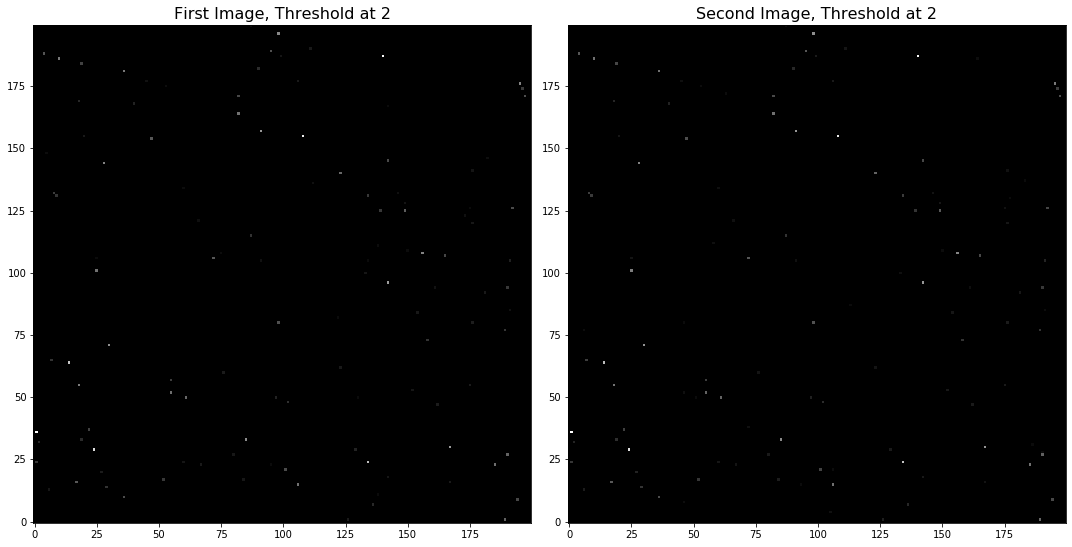

In [22]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,15)

ax[0].imshow(clean[0].reshape(200,200),origin='lower',cmap=plt.cm.gray)
ax[0].set_title('First Image, Threshold at 2',fontsize=16)

ax[1].imshow(clean[1].reshape(200,200),origin='lower',cmap=plt.cm.gray)
ax[1].set_title('Second Image, Threshold at 2',fontsize=16)

fig.tight_layout()

These look quite pretty! From the beginning of the problem, we determined that the largest pixel value (aka largest source in this field) is around 46. I will define a faint star as one that is between a pixel value of 2 and 15, and set an upper threshold to exclude any pixels with larger than 15.

In [23]:
high_thresh = 15.

for i in range(10):
    for j in range(200*200):
        if clean[i][j] > high_thresh:
            clean[i][j] = 0.
            
clean[0].max()

14.79326489621035


We can begin to visually distinguish between images... our first image has a star in the top center missing from the second image.



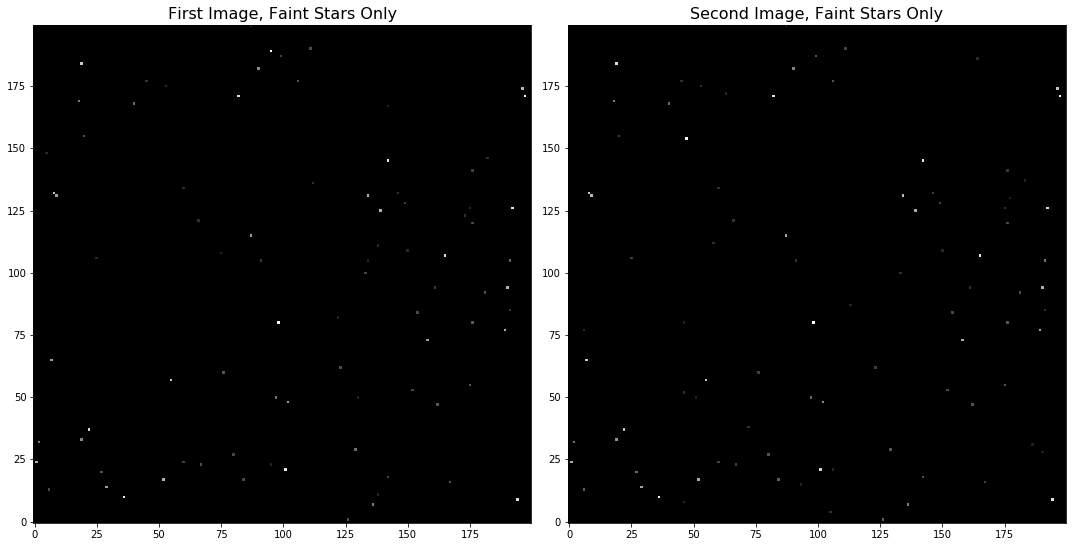

In [24]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,15)

ax[0].imshow(clean[0].reshape(200,200),origin='lower',cmap=plt.cm.gray)
ax[0].set_title('First Image, Faint Stars Only',fontsize=16)

ax[1].imshow(clean[1].reshape(200,200),origin='lower',cmap=plt.cm.gray)
ax[1].set_title('Second Image, Faint Stars Only',fontsize=16)

fig.tight_layout()

print('\nWe can begin to visually distinguish between images... our first image has a star in the top center missing from the second image.\n')

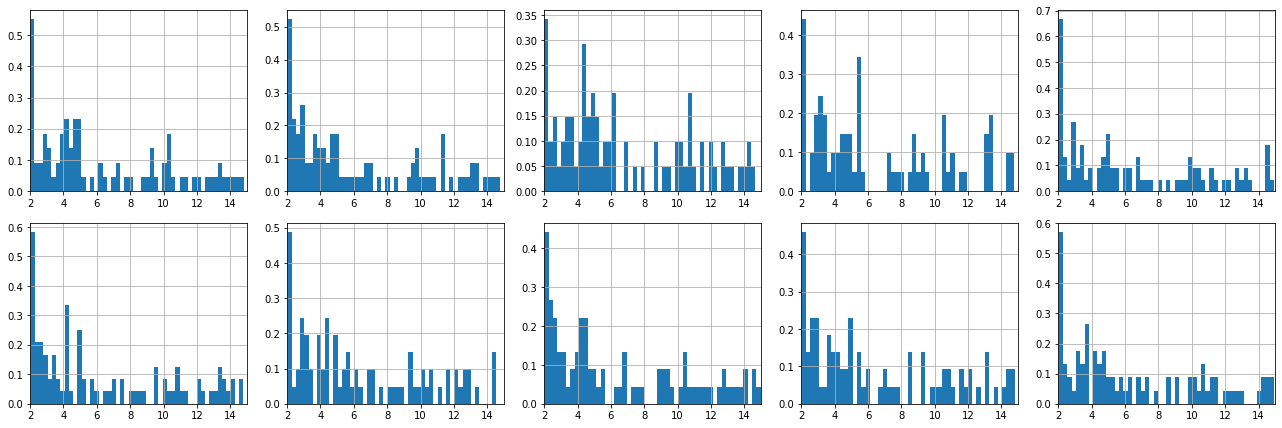

In [25]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(18,6)

for i in range(10):
    if i <= 4:
        ax[0,i].hist(clean[i][clean[i] != 0.],bins=50,density=True);
        ax[0,i].set_xlim(2,15)
        ax[0,i].grid()
    if i > 4:
        ax[1,i-5].hist(clean[i][clean[i] != 0.],bins=50,density=True);
        ax[1,i-5].set_xlim(2,15)
        ax[1,i-5].grid()

fig.tight_layout()

We can see from the histograms above of the cleaned arrays consisting of pixel values 2 to 15 (excluding 0) that there is actually a fair amount of variation, at least when the bin is 0.26. This tells me that atmospheric seeing will shift these faint stairs in pixel value a substantial amount from image to image. If we recreate these plots and assume that there will be a variation of at least 1 (so a bin of 13), we have a fairly reliable characterization of our faintest stars.

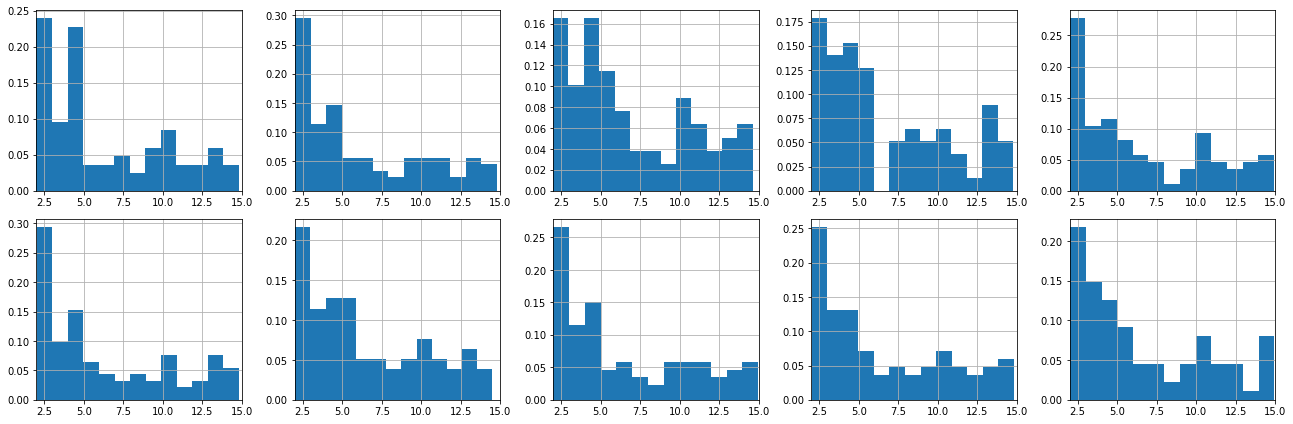

In [26]:
fig, ax = plt.subplots(2,5)
fig.set_size_inches(18,6)

for i in range(10):
    if i <= 4:
        ax[0,i].hist(clean[i][clean[i] != 0.],bins=13,density=True);
        ax[0,i].set_xlim(2,15)
        ax[0,i].grid()
    if i > 4:
        ax[1,i-5].hist(clean[i][clean[i] != 0.],bins=13,density=True);
        ax[1,i-5].set_xlim(2,15)
        ax[1,i-5].grid()

fig.tight_layout()

Whoa. This is actually way more variation than I expected. Especially with our third image and its random peaks. I suppose it can be explained by intense atmospheric seeing, which isn't uncommon.

In conclusion, the exclusion and inclusion of certain values or intervals of values wholly determines the pdf you consider to be background. I'm sure all these stars were considered to be background by Haowen, whereas it is my target signal.